Consulta realizada nas Notas de Lançamento Contábeis no SIGEF por meio do evento nº 540905 (APROPRIAÇÃO DE PRECATÓRIOS) - Totais por mês.
Após a apropriação do saldo é confeccionado as Preparação Pagamento (Extra Orçamentaria) evento precatorios 700023 - valores individuais boletos
Janeiro e Fevereiro de 2022 foram pagamentos por ofício, não hã NL, apenas PP e OBs. 

In [28]:
import duckdb
import pandas as pd
import numpy as np
import os

PAI_DIR = os.getcwd()  # diretório atual para notebooks jupyter
DATA_RAW = os.path.join(PAI_DIR, "data", "raw")
DATA_PROCESSED = os.path.join(PAI_DIR, "data", "processed")
SCRIPTS = os.path.join(PAI_DIR, "scripts")

# pd.set_option("display.float_format", "{:,.0f}".format)

In [45]:
!python {os.path.join(SCRIPTS, 'elt_precatorios.py')}

✅ Arquivo salvo: c:\Users\00526862130\Projetos\sefin_geop\notebooks\data\raw\precatorios.parquet


c:\Users\00526862130\Projetos\sefin_geop\notebooks\scripts\gerar_parquet.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, con=connection)


In [2]:
con = duckdb.connect(database=':memory:')

In [3]:
caminho = os.path.join(DATA_RAW, 'precatorios.parquet')
nome_tabela = 'precatorios'
con.execute(f"""
    CREATE TABLE IF NOT EXISTS {nome_tabela} AS
    SELECT * FROM '{caminho}'
""")

df_precatorios = con.execute(f"SELECT * FROM {nome_tabela}").df()

df_precatorios.head(2)

,SIGEF_DB,NUSEQ,CDUNIDADEGESTORAORIGEM,CDGESTAOORIGEM,CDGESTAODESTINO,CDUNIDADEGESTORADESTINO,CDCONTACONTABIL,CDEVENTO,NUCONTACORRENTE,NUDOCUMENTO,...,CDNATUREZADESPESACC,CDGRUPOPROGFINCC,CDCONTRATOEMPRESTIMOCC,CDPARCELACONTRATOEMPCC,CDNATUREZADESPESADETCC,CDTIPOCREDORCC,NUMESCC,NURETENCAOCC,NUDOCUMENTOCC,CT_CARGA_EM
0,SIGEF2024,9567024,140099,1,1,140099,79820000000,540905,None,2024NL019712,...,<NA>,<NA>,<NA>,<NA>,<NA>,None,<NA>,<NA>,<NA>,2025-03-13 19:21:00.313116
1,SIGEF2024,9567025,140099,1,1,140099,89823010000,540905,090077,2024NL019712,...,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,2025-03-13 19:21:00.313116


In [4]:
df_precatorios = con.execute("""
            SELECT
                SUBSTRING(SIGEF_DB, 6, 4) AS ANO,
                EXTRACT(MONTH FROM DTREFERENCIA) AS MES,
                SUM(CASE WHEN FLESTORNO = 0 THEN VLLANCAMENTO ELSE -VLLANCAMENTO END) AS VALOR
            FROM precatorios
            WHERE INSINAL = 'C' 
            GROUP BY 1,2
            ORDER BY 1,2
            """).df()

In [5]:
df_precatorios.head(5)

,ANO,MES,VALOR
0,2022,3,24000000.00
1,2022,4,24710332.92
2,2022,5,11722616.96
3,2022,6,12075475.30
4,2022,7,12539877.28


In [6]:
df_precatorios.describe()

,MES,VALOR
count,42.000000,4.200000e+01
mean,6.357143,2.736510e+07
std,3.318988,6.520681e+06
min,1.000000,1.172262e+07
25%,4.000000,2.625208e+07
50%,6.000000,2.743928e+07
75%,9.000000,3.223584e+07
max,12.000000,3.510788e+07


In [7]:
import matplotlib.pyplot as plt

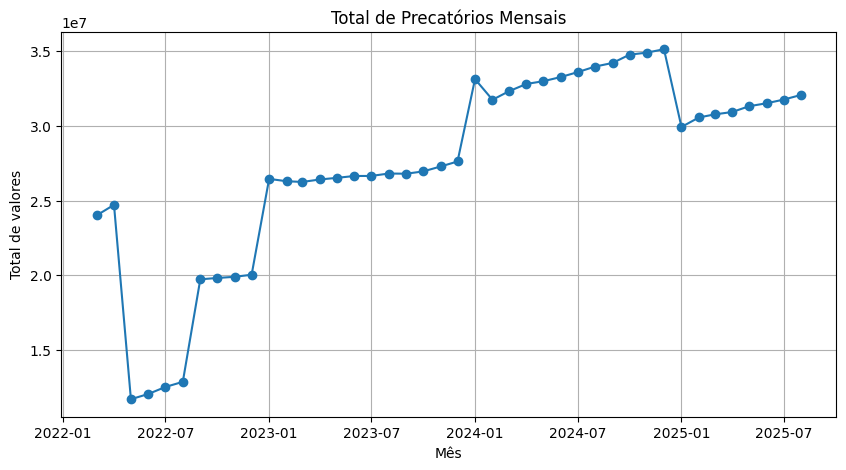

In [8]:
df_precatorios['DATA'] = pd.to_datetime(
	df_precatorios.rename(columns={'ANO': 'year', 'MES': 'month'})[['year', 'month']].assign(day=1)
)

plt.figure(figsize=(10,5))
plt.plot(df_precatorios['DATA'], df_precatorios['VALOR'], marker='o')
plt.title("Total de Precatórios Mensais")
plt.xlabel("Mês")
plt.ylabel("Total de valores")
plt.grid(True)
plt.show()

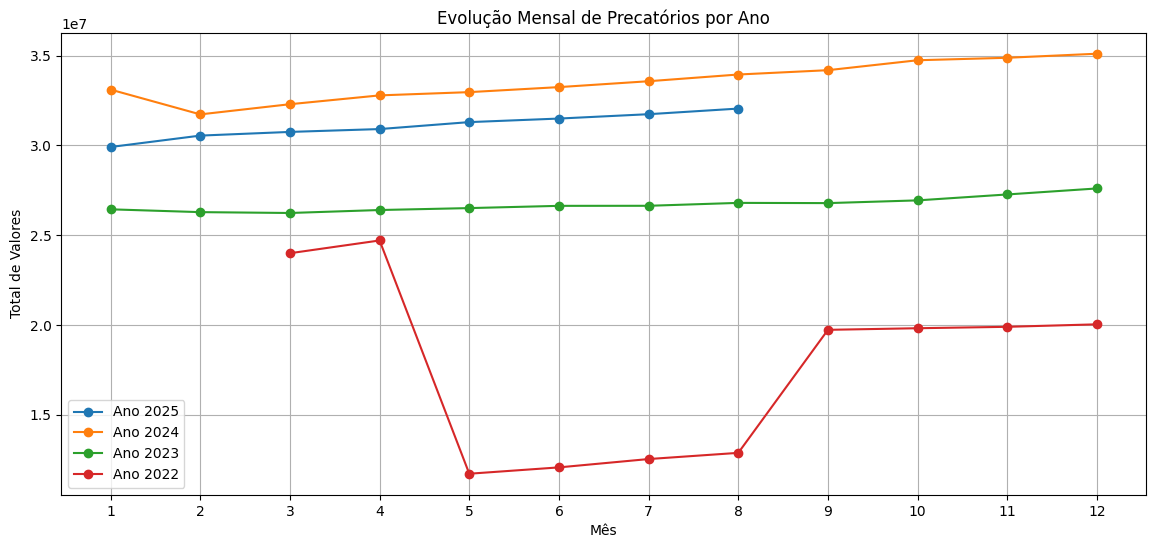

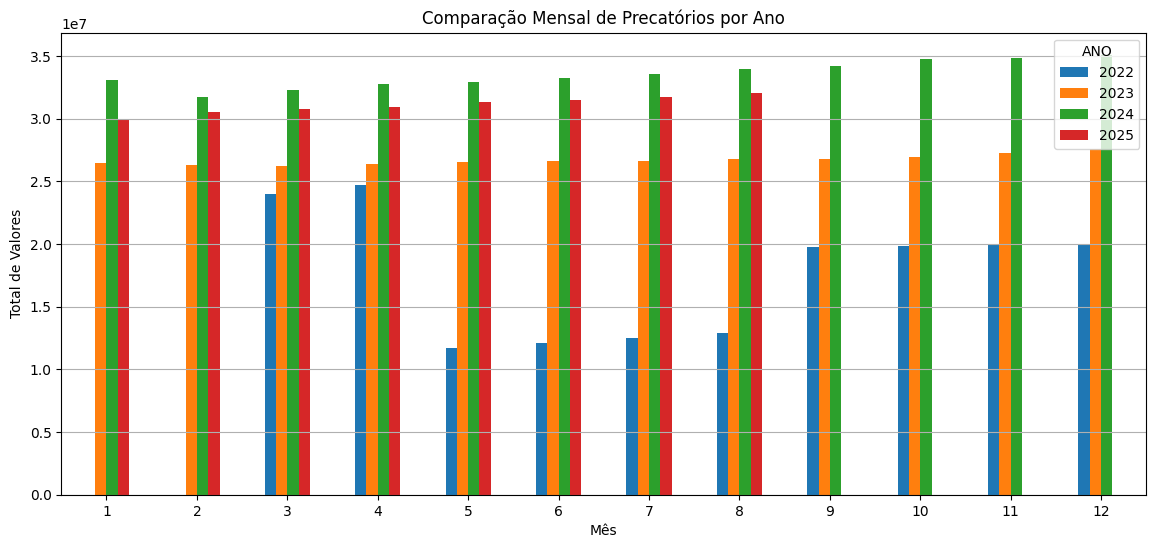

C:\Users\00526862130\AppData\Local\Temp\ipykernel_5176\2511188866.py:36: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_var = df_pivot.pct_change(axis=1) * 100


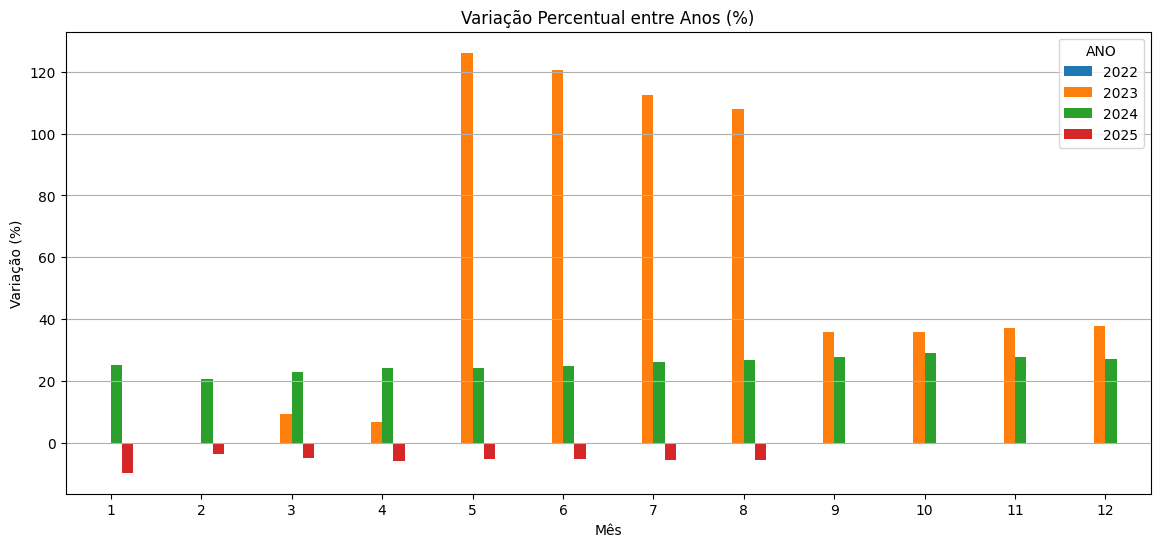

In [9]:
# Extraindo ano e mês para conveniência
df_precatorios['ANO'] = df_precatorios['DATA'].dt.year
df_precatorios['MES'] = df_precatorios['DATA'].dt.month

anos = sorted(df_precatorios['ANO'].unique(), reverse=True)
meses = range(1,13)

plt.figure(figsize=(14,6))

# ---- Linha de evolução mensal por ano ----
for ano in anos:
    df_ano = df_precatorios[df_precatorios['ANO'] == ano]
    plt.plot(df_ano['MES'], df_ano['VALOR'], marker='o', label=f"Ano {ano}")

plt.title("Evolução Mensal de Precatórios por Ano")
plt.xlabel("Mês")
plt.ylabel("Total de Valores")
plt.xticks(meses)
plt.grid(True)
plt.legend()
plt.show()

# ---- Comparação de barras entre anos ----
df_pivot = df_precatorios.pivot(index='MES', columns='ANO', values='VALOR')
df_pivot.plot(kind='bar', figsize=(14,6))
plt.title("Comparação Mensal de Precatórios por Ano")
plt.xlabel("Mês")
plt.ylabel("Total de Valores")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# ---- Variação percentual mês a mês entre anos ----
# Exemplo: ano mais recente vs anterior
if len(anos) > 1:
    df_var = df_pivot.pct_change(axis=1) * 100
    df_var.plot(kind='bar', figsize=(14,6))
    plt.title("Variação Percentual entre Anos (%)")
    plt.xlabel("Mês")
    plt.ylabel("Variação (%)")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

In [54]:
!python {os.path.join(SCRIPTS, 'inflacao.py')}

Traceback (most recent call last):
  File "c:\Users\00526862130\AppData\Local\anaconda3\envs\condavenv\Lib\site-packages\urllib3\connectionpool.py", line 464, in _make_request
    self._validate_conn(conn)
  File "c:\Users\00526862130\AppData\Local\anaconda3\envs\condavenv\Lib\site-packages\urllib3\connectionpool.py", line 1093, in _validate_conn
    conn.connect()
  File "c:\Users\00526862130\AppData\Local\anaconda3\envs\condavenv\Lib\site-packages\urllib3\connection.py", line 741, in connect
    sock_and_verified = _ssl_wrap_socket_and_match_hostname(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\00526862130\AppData\Local\anaconda3\envs\condavenv\Lib\site-packages\urllib3\connection.py", line 920, in _ssl_wrap_socket_and_match_hostname
    ssl_sock = ssl_wrap_socket(
               ^^^^^^^^^^^^^^^^
  File "c:\Users\00526862130\AppData\Local\anaconda3\envs\condavenv\Lib\site-packages\urllib3\util\ssl_.py", line 480, in ssl_wrap_socket
    ssl_sock = _ss

In [10]:
caminho = os.path.join(DATA_RAW, 'inflacao_ipca.parquet')
nome_tabela = 'inflacao_ipca'
con.execute(f"""
    CREATE TABLE IF NOT EXISTS {nome_tabela} AS
    SELECT * FROM '{caminho}'
""")

In [11]:
df_inflacao_ipca = con.execute("""
            SELECT * FROM inflacao_ipca
""").df()

df_inflacao_ipca

,brasil,indicador,valor,unidade,ANO,MES
0,Brasil,IPCA - Variação mensal,0.21,%,2020,1
1,Brasil,IPCA - Variação acumulada no ano,0.21,%,2020,1
2,Brasil,IPCA - Variação acumulada em 12 meses,...,,2020,1
3,Brasil,IPCA - Peso mensal,100.0000,%,2020,1
4,Brasil,IPCA - Variação mensal,0.25,%,2020,2
...,...,...,...,...,...,...
263,Brasil,IPCA - Peso mensal,100.0000,%,2025,6
264,Brasil,IPCA - Variação mensal,0.26,%,2025,7
265,Brasil,IPCA - Variação acumulada no ano,3.26,%,2025,7
266,Brasil,IPCA - Variação acumulada em 12 meses,5.23,%,2025,7


In [12]:
ipca_mensal = df_inflacao_ipca[df_inflacao_ipca['indicador'] == "IPCA - Variação mensal"].copy()

# Convert 'valor' column to numeric
ipca_mensal['valor'] = pd.to_numeric(ipca_mensal['valor'], errors='coerce')

ipca_mensal['DATA'] = pd.to_datetime(dict(year=ipca_mensal['ANO'], month=ipca_mensal['MES'], day=1))

ipca_mensal = ipca_mensal.sort_values('DATA')

ipca_mensal['FATOR'] = (1 + ipca_mensal['valor']/100).cumprod()

ipca_mensal['INDICE'] = ipca_mensal['FATOR'] / ipca_mensal['FATOR'].iloc[0] * 100

df_precatorios['DATA_BASE'] = pd.to_datetime(dict(year=df_precatorios['ANO'], month=df_precatorios['MES'], day=1))
df_merged = df_precatorios.merge(ipca_mensal[['DATA','INDICE']], left_on='DATA_BASE', right_on='DATA', how='left')

indice_final = ipca_mensal['INDICE'].iloc[-1]

df_merged['VALOR_CORRIGIDO'] = df_merged['VALOR'] * (indice_final / df_merged['INDICE'])

df_precatorios = df_merged.copy()

df_precatorios

,ANO,MES,VALOR,DATA_x,DATA_BASE,DATA_y,INDICE,VALOR_CORRIGIDO
0,2022,3,24000000.00,2022-03-01,2022-03-01,2022-03-01,118.465913,2.786085e+07
1,2022,4,24710332.92,2022-04-01,2022-04-01,2022-04-01,119.721652,2.838458e+07
2,2022,5,11722616.96,2022-05-01,2022-05-01,2022-05-01,120.284343,1.340269e+07
3,2022,6,12075475.30,2022-06-01,2022-06-01,2022-06-01,121.090249,1.371423e+07
4,2022,7,12539877.28,2022-07-01,2022-07-01,2022-07-01,120.266835,1.433917e+07
5,2022,8,12884342.65,2022-08-01,2022-08-01,2022-08-01,119.833874,1.478629e+07
6,2022,9,19734553.41,2022-09-01,2022-09-01,2022-09-01,119.486356,2.271358e+07
7,2022,10,19823464.74,2022-10-01,2022-10-01,2022-10-01,120.191326,2.268208e+07
8,2022,11,19902244.86,2022-11-01,2022-11-01,2022-11-01,120.684110,2.267924e+07
9,2022,12,20040801.21,2022-12-01,2022-12-01,2022-12-01,121.432351,2.269641e+07


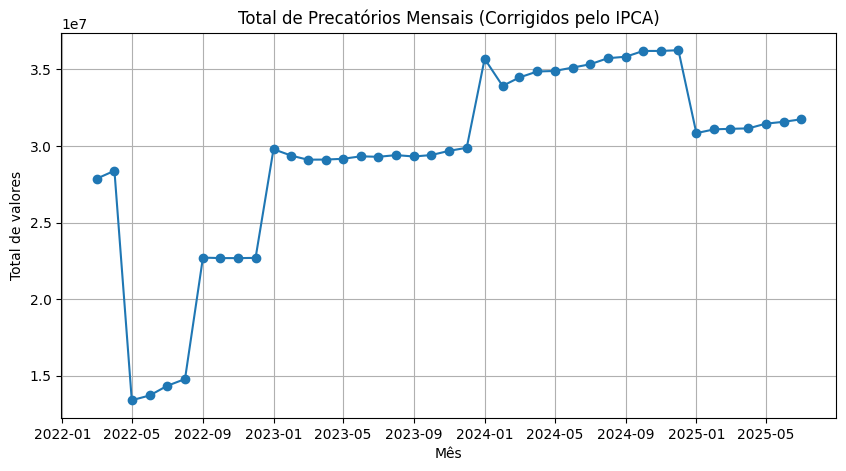

In [13]:
df_precatorios['DATA'] = pd.to_datetime(
	df_precatorios.rename(columns={'ANO': 'year', 'MES': 'month'})[['year', 'month']].assign(day=1)
)

plt.figure(figsize=(10,5))
plt.plot(df_precatorios['DATA'], df_precatorios['VALOR_CORRIGIDO'], marker='o')
plt.title("Total de Precatórios Mensais (Corrigidos pelo IPCA)")
plt.xlabel("Mês")
plt.ylabel("Total de valores")
plt.grid(True)
plt.show()

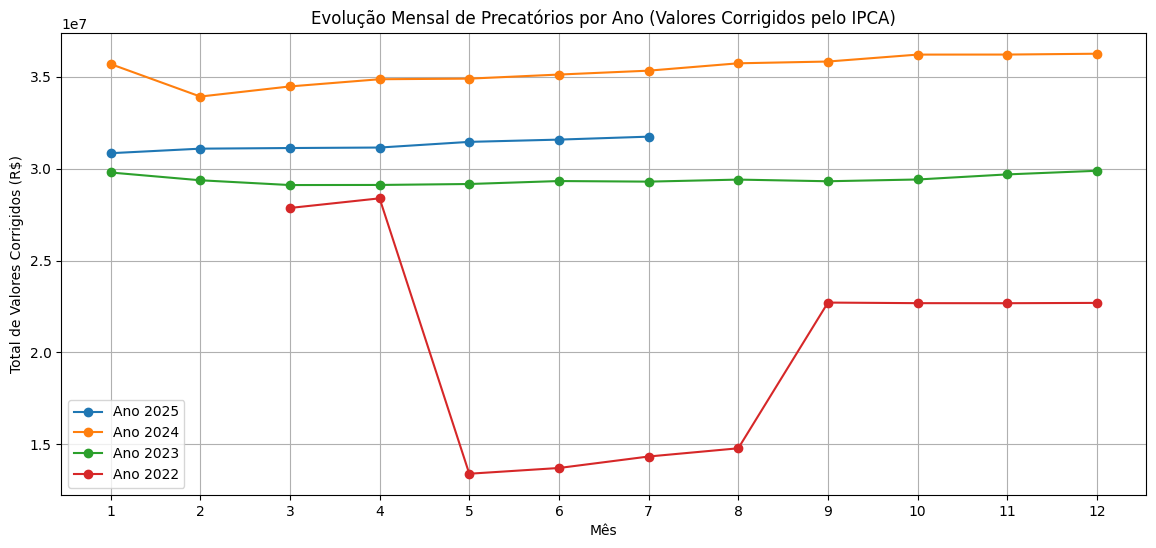

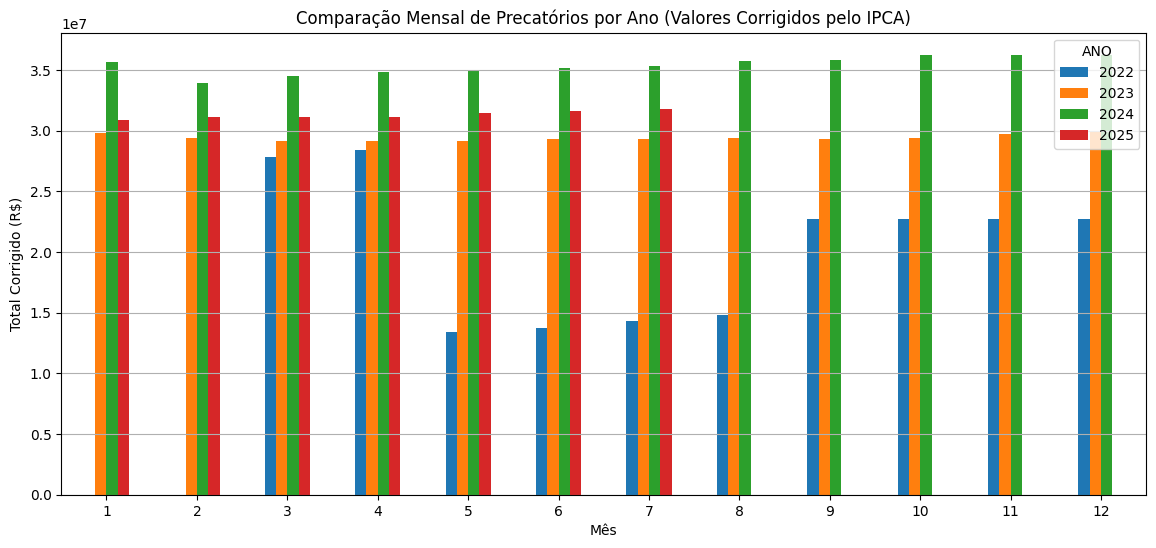

C:\Users\00526862130\AppData\Local\Temp\ipykernel_5176\3150443905.py:31: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_var = df_pivot.pct_change(axis=1) * 100


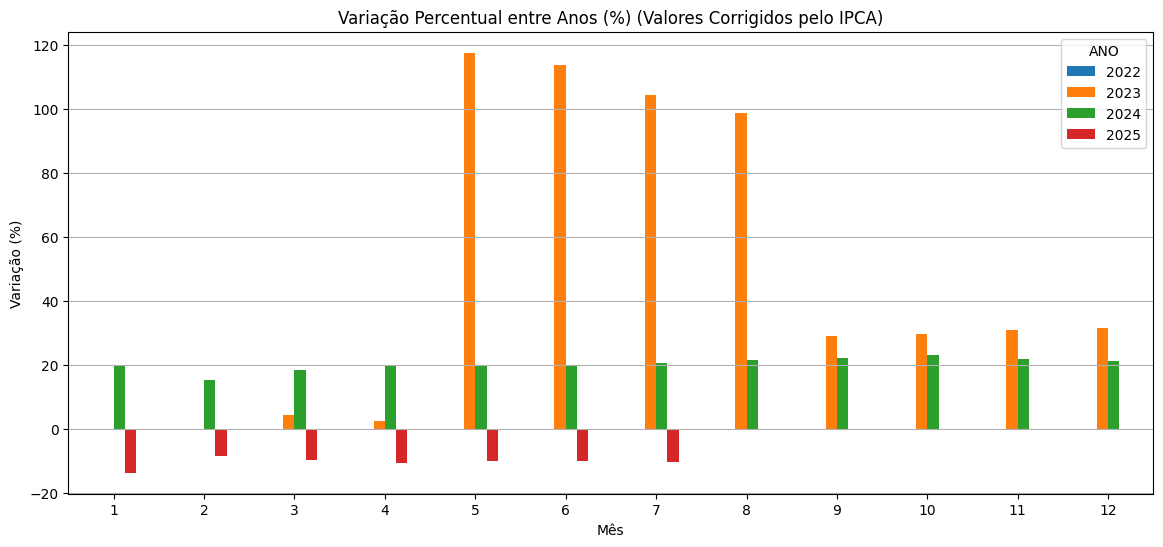

In [14]:
anos = sorted(df_precatorios['ANO'].unique(), reverse=True)
meses = range(1,13)

plt.figure(figsize=(14,6))

for ano in anos:
    df_ano = df_precatorios[df_precatorios['ANO'] == ano]
    plt.plot(df_ano['MES'], df_ano['VALOR_CORRIGIDO'], marker='o', label=f"Ano {ano}")

plt.title("Evolução Mensal de Precatórios por Ano (Valores Corrigidos pelo IPCA)")
plt.xlabel("Mês")
plt.ylabel("Total de Valores Corrigidos (R$)")
plt.xticks(meses)
plt.grid(True)
plt.legend()
plt.show()

# Comparação em barras corrigidas
df_pivot = df_precatorios.pivot(index='MES', columns='ANO', values='VALOR_CORRIGIDO')
df_pivot.plot(kind='bar', figsize=(14,6))
plt.title("Comparação Mensal de Precatórios por Ano (Valores Corrigidos pelo IPCA)")
plt.xlabel("Mês")
plt.ylabel("Total Corrigido (R$)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# ---- Variação percentual mês a mês entre anos ----
# Exemplo: ano mais recente vs anterior
if len(anos) > 1:
    df_var = df_pivot.pct_change(axis=1) * 100
    df_var.plot(kind='bar', figsize=(14,6))
    plt.title("Variação Percentual entre Anos (%) (Valores Corrigidos pelo IPCA)")
    plt.xlabel("Mês")
    plt.ylabel("Variação (%)")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()


In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [25]:
df_precatorios_f = df_precatorios[['ANO','MES','VALOR','DATA_BASE','INDICE','VALOR_CORRIGIDO']].copy()

df_precatorios_f['VALOR_CORRIGIDO'] = df_precatorios_f.apply(
    lambda row: row['VALOR'] if pd.isna(row['VALOR_CORRIGIDO']) else row['VALOR_CORRIGIDO'], axis=1
)

df_precatorios_f['VALOR'] = df_precatorios_f['VALOR'].apply(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
df_precatorios_f['VALOR_CORRIGIDO'] = df_precatorios_f['VALOR_CORRIGIDO'].apply(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

df_precatorios_f["INDICE"] = df_precatorios_f["INDICE"].interpolate(method="linear")

df_precatorios_f

,ANO,MES,VALOR,DATA_BASE,INDICE,VALOR_CORRIGIDO
0,2022,3,"24.000.000,00",2022-03-01,118.465913,"27.860.849,33"
1,2022,4,"24.710.332,92",2022-04-01,119.721652,"28.384.576,09"
2,2022,5,"11.722.616,96",2022-05-01,120.284343,"13.402.690,48"
3,2022,6,"12.075.475,30",2022-06-01,121.090249,"13.714.234,75"
4,2022,7,"12.539.877,28",2022-07-01,120.266835,"14.339.166,93"
5,2022,8,"12.884.342,65",2022-08-01,119.833874,"14.786.288,70"
6,2022,9,"19.734.553,41",2022-09-01,119.486356,"22.713.575,35"
7,2022,10,"19.823.464,74",2022-10-01,120.191326,"22.682.083,96"
8,2022,11,"19.902.244,86",2022-11-01,120.684110,"22.679.239,59"
9,2022,12,"20.040.801,21",2022-12-01,121.432351,"22.696.411,20"


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [35]:
df_precatorios_p = df_precatorios.copy()

df_precatorios_p['VALOR_CORRIGIDO'] = df_precatorios_p.apply(
    lambda row: row['VALOR'] if pd.isna(row['VALOR_CORRIGIDO']) else row['VALOR_CORRIGIDO'], axis=1
)

df_precatorios_p["INDICE"] = df_precatorios_p["INDICE"].interpolate(method="linear")

# --- 2. Previsão com Exponential Smoothing ---
# Usamos VALOR_CORRIGIDO como série principal
serie = df_precatorios_p.set_index("DATA_BASE")["VALOR_CORRIGIDO"]

# Ajuste do modelo (sem sazonalidade explícita, pois temos poucos meses)
modelo = ExponentialSmoothing(serie, trend="add").fit()

# Previsão para os próximos 6 meses
previsao = modelo.forecast(6)

# Converter previsão em DataFrame para facilitar
previsao_df = previsao.reset_index()
previsao_df.columns = ["DATA_BASE", "VALOR_PREVISTO"]

# Formatar valores no padrão brasileiro
previsao_df["VALOR_PREVISTO_BR"] = previsao_df["VALOR_PREVISTO"].apply(
    lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
)

print("\nPrevisão próximos meses (formatada):")
print(previsao_df[['DATA_BASE', 'VALOR_PREVISTO_BR']])


Previsão próximos meses (formatada):
   DATA_BASE VALOR_PREVISTO_BR
0 2025-09-01     32.454.872,79
1 2025-10-01     32.847.467,31
2 2025-11-01     33.240.061,83
3 2025-12-01     33.632.656,36
4 2026-01-01     34.025.250,88
5 2026-02-01     34.417.845,40


c:\Users\00526862130\AppData\Local\anaconda3\envs\condavenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
